In [1]:
!pip install yfinance tensorflow scikit-learn matplotlib joblib


In [2]:
import yfinance as yf
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt


In [3]:
# Choose stock
ticker = "AAPL"

# Download training data
today = datetime.date.today().strftime("%Y-%m-%d")
data = yf.download(ticker, start="2018-01-01", end=today)
close_data = data[['Close']].values

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train
model.fit(X, y, batch_size=32, epochs=10)

# Save model & scaler
model.save("stock_rnn_model.h5")
joblib.dump(scaler, "scaler.pkl")


/tmp/ipython-input-2846492101.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end=today)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0578
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0041
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0030
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0024
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0023
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0020
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0020
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0017
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0016


['scaler.pkl']

In [4]:
# Load model & scaler
model = tf.keras.models.load_model("stock_rnn_model.h5")
scaler = joblib.load("scaler.pkl")

# Fetch last 120 days
past = (datetime.date.today() - datetime.timedelta(days=120)).strftime("%Y-%m-%d")
data = yf.download(ticker, start=past, end=today)
close_data = data[['Close']].values
scaled_data = scaler.transform(close_data)

# Last 60 days for prediction
last_60 = scaled_data[-60:]
X_test = np.reshape(last_60, (1, last_60.shape[0], 1))

# Predict
predicted_scaled = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"📈 Predicted {ticker} next closing price: {predicted_price[0][0]:.2f} USD")


/tmp/ipython-input-769537161.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=past, end=today)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
📈 Predicted AAPL next closing price: 225.93 USD


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


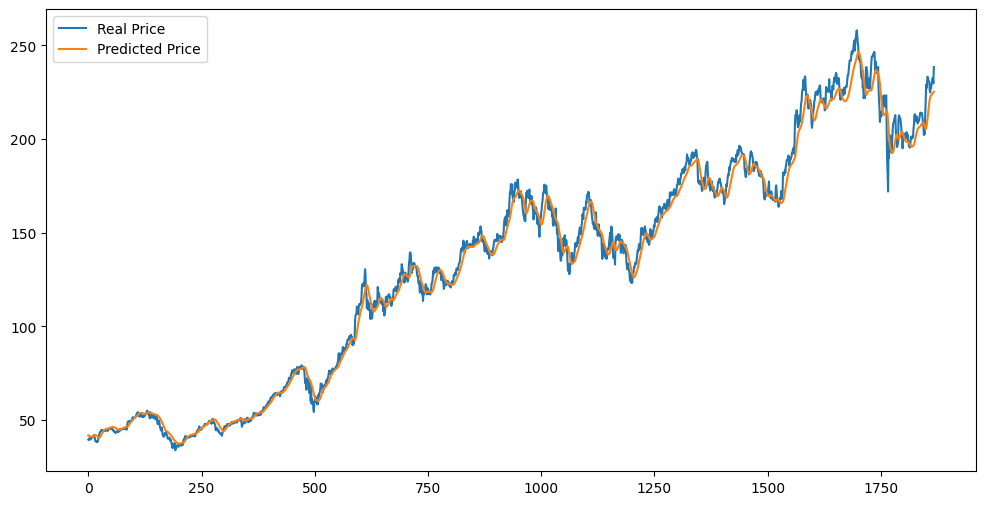

In [5]:
# Predict for training data (just to compare fit)
predicted_train = model.predict(X)
predicted_train = scaler.inverse_transform(predicted_train)
real_train = scaler.inverse_transform(y.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(real_train, label="Real Price")
plt.plot(predicted_train, label="Predicted Price")
plt.legend()
plt.show()


In [6]:
from IPython.display import HTML

HTML("""
<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container">
  <div id="tradingview_chart"></div>
  <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
  <script type="text/javascript">
    new TradingView.widget({
      "width": 980,
      "height": 610,
      "symbol": "NASDAQ:AAPL",   // Change ticker here
      "interval": "D",
      "timezone": "Etc/UTC",
      "theme": "light",
      "style": "1",
      "locale": "en",
      "toolbar_bg": "#f1f3f6",
      "enable_publishing": false,
      "allow_symbol_change": true,
      "container_id": "tradingview_chart"
    });
  </script>
</div>
<!-- TradingView Widget END -->
""")


In [7]:
def tradingview_widget(ticker="AAPL"):
    from IPython.display import HTML
    return HTML(f"""
    <div class="tradingview-widget-container">
      <div id="tradingview_chart"></div>
      <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
      <script type="text/javascript">
        new TradingView.widget({{
          "width": 980,
          "height": 610,
          "symbol": "NASDAQ:{ticker}",
          "interval": "D",
          "timezone": "Etc/UTC",
          "theme": "light",
          "style": "1",
          "locale": "en",
          "toolbar_bg": "#f1f3f6",
          "enable_publishing": false,
          "allow_symbol_change": true,
          "container_id": "tradingview_chart"
        }});
      </script>
    </div>
    """)

# Example usage
tradingview_widget("TSLA")
